In [3]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

In [9]:
bs = 100
batch_size = 100
device = torch.device("cpu") 
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)
real_samples, mnist_labels = next(iter(train_loader))

In [5]:
## GAN 
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output
    
    
discriminator = Discriminator().to(device=device)


In [6]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

generator = Generator().to(device=device)


In [7]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [10]:
for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(
            device=device
        )
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros((batch_size, 1)).to(
            device=device
        )
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels)
        )

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels
        )
        loss_discriminator.backward()
        optimizer_discriminator.step()

        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(
            device=device
        )

        # Training the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels
        )
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.4774854779243469
Epoch: 0 Loss G.: 1.0584931373596191
Epoch: 1 Loss D.: 0.019214604049921036
Epoch: 1 Loss G.: 3.998481035232544
Epoch: 2 Loss D.: 0.14087344706058502
Epoch: 2 Loss G.: 4.956723690032959
Epoch: 3 Loss D.: 0.04634331539273262
Epoch: 3 Loss G.: 7.517075061798096
Epoch: 4 Loss D.: 0.08306708931922913
Epoch: 4 Loss G.: 5.247803211212158
Epoch: 5 Loss D.: 0.004760336130857468
Epoch: 5 Loss G.: 7.496007919311523
Epoch: 6 Loss D.: 0.010298875160515308
Epoch: 6 Loss G.: 7.239740371704102
Epoch: 7 Loss D.: 0.010075602680444717
Epoch: 7 Loss G.: 9.394571304321289
Epoch: 8 Loss D.: 0.030054347589612007
Epoch: 8 Loss G.: 11.212420463562012
Epoch: 9 Loss D.: 0.030345816165208817
Epoch: 9 Loss G.: 8.697339057922363
Epoch: 10 Loss D.: 0.010069004260003567
Epoch: 10 Loss G.: 8.766011238098145
Epoch: 11 Loss D.: 0.003239551791921258
Epoch: 11 Loss G.: 7.806920051574707
Epoch: 12 Loss D.: 0.040872979909181595
Epoch: 12 Loss G.: 8.404668807983398
Epoch: 13 Loss D.: 0.0

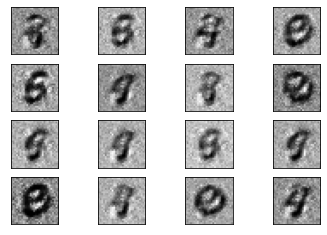

In [11]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.cpu().detach()
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [ ]:
## VAE

In [16]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=2)
optimizer = optim.Adam(vae.parameters())

In [13]:
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD




def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
    
    
    
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            # data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [17]:
for epoch in range(num_epochs):
    train(epoch)
    test()

====> Epoch: 0 Average loss: 177.8781
====> Test set loss: 162.6710
====> Epoch: 1 Average loss: 157.9029
====> Test set loss: 154.1522
====> Epoch: 2 Average loss: 152.5037
====> Test set loss: 150.8753
====> Epoch: 3 Average loss: 149.5267
====> Test set loss: 148.2402
====> Epoch: 4 Average loss: 147.3033
====> Test set loss: 146.8252
====> Epoch: 5 Average loss: 145.9060
====> Test set loss: 146.1991
====> Epoch: 6 Average loss: 144.6978
====> Test set loss: 145.2208
====> Epoch: 7 Average loss: 143.8803
====> Test set loss: 143.9406
====> Epoch: 8 Average loss: 143.0849
====> Test set loss: 143.8107
====> Epoch: 9 Average loss: 142.3656
====> Test set loss: 142.7585
====> Epoch: 10 Average loss: 141.6556
====> Test set loss: 143.1767
====> Epoch: 11 Average loss: 141.2618
====> Test set loss: 142.2897
====> Epoch: 12 Average loss: 140.7838
====> Test set loss: 142.0607
====> Epoch: 13 Average loss: 140.5853
====> Test set loss: 142.0494
====> Epoch: 14 Average loss: 140.1620
====>

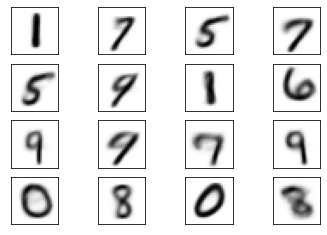

In [18]:
z = torch.randn(100, 2)
sample = vae.decoder(z).detach()


for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(sample[i].reshape(28, 28), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])